# Named Entity Recognition

## Importing Dependencies

In [55]:
import tensorflow as tf 
import pandas as pd
import numpy as np 
import json 
import random 
import logging 
import re 
import matplotlib.pyplot as plt 

from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import DistilBertTokenizerFast

tf.get_logger().setLevel('ERROR')

## GPU Acceleration

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus[0])
if gpus: 
    for gpu in gpus: 
        tf.config.experimental.set_virtual_device_configuration(gpu,
                                                               [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Named Entity Recognition to process resumes 

Named-entity recognition (NER) is a problem that has a goal to locate and classify named entities mentioned in unstructured text into pre-defined categories such as person names, organizations, locations, medical codes, time expressions, etc.

NER is used in many fields in NPL and it can help to answer some questions such as:
- Which companies and persons are mentioned in the documents?
- In which articles or posts is specified product mentioned?
- Does the article contain medical terms and which ones?
  
State-of-the-art NER systems for English produce near-human performance where the best system scored 93.39% of F-measure while human annotators have a score around 97%.

Named-entity recognition is often broken down into two distinct problems:
- Detection of names
- Classification of the names by the type of entity they refer to (person, organization or location)
- Detection of names is typical simplified to a segmentation problem where a single name might be constructed of several substrings. For example "Bank of America" is a single name despite that the substring "America" is itself a name. Classification of names requires choosing an ontology by which to organize categories of things.

While doing NER, besides the correct and incorrect predicted terms, we'll probably face some "partially correct" predictions. For example:
- Uncomplete names (missing the last token of "John Smith, M.D.")
- Names with more tokens (including the "mr." token in "mr. John Smith")
- Partitioning adjacent entities differently (treating two names as one "Hans, Jones Blick")
- Assigning related but inexact type (for example, "substance" vs. "drug", or "school" vs. "organization")
- Correctly identifying an entity, when what the user wanted was a smaller- or larger-scope entity (for example, identifying "James Madison" as a personal name, when it's part of "James Madison University")

## Dataset Cleaning 

In this notebook, we will optimize a transformer model on a dataset of resumes

In [3]:
df_data = pd.read_json('ner.json', lines=True)
df_data = df_data.drop(['extras'], axis=1)
df_data['content'] = df_data['content'].str.replace("\n"," ")

In [4]:
df_data.head()

,content,annotation
0,Abhishek Jha Application Development Associate...,"[{'label': ['Skills'], 'points': [{'start': 12..."
1,Afreen Jamadar Active member of IIIT Committee...,"[{'label': ['Email Address'], 'points': [{'sta..."
2,"Akhil Yadav Polemaina Hyderabad, Telangana - E...","[{'label': ['Skills'], 'points': [{'start': 37..."
3,Alok Khandai Operational Analyst (SQL DBA) Eng...,"[{'label': ['Skills'], 'points': [{'start': 80..."
4,Ananya Chavan lecturer - oracle tutorials Mum...,"[{'label': ['Degree'], 'points': [{'start': 20..."


In [5]:
df_data.iloc[0]['annotation']

[{'label': ['Skills'],
  'points': [{'start': 1295,
    'end': 1621,
    'text': '\n• Programming language: C, C++, Java\n• Oracle PeopleSoft\n• Internet Of Things\n• Machine Learning\n• Database Management System\n• Computer Networks\n• Operating System worked on: Linux, Windows, Mac\n\nNon - Technical Skills\n\n• Honest and Hard-Working\n• Tolerant and Flexible to Different Situations\n• Polite and Calm\n• Team-Player'}]},
 {'label': ['Skills'],
  'points': [{'start': 993,
    'end': 1153,
    'text': 'C (Less than 1 year), Database (Less than 1 year), Database Management (Less than 1 year),\nDatabase Management System (Less than 1 year), Java (Less than 1 year)'}]},
 {'label': ['College Name'],
  'points': [{'start': 939, 'end': 956, 'text': 'Kendriya Vidyalaya'}]},
 {'label': ['College Name'],
  'points': [{'start': 883, 'end': 904, 'text': 'Woodbine modern school'}]},
 {'label': ['Graduation Year'],
  'points': [{'start': 856, 'end': 860, 'text': '2017\n'}]},
 {'label': ['College 

Now, we write a function that merges overlapping intervals that have the same identifier, which is important for:
- Cleaning up inconsistent annotations
- Resolving overlapping entity mentions
- Preparing clean, non-overlapping spans for transformer-based NER training

In [6]:
def merge_intervals(intervals): 
    # Sort Intervals based on start time(first interval of each tuple) 
    sorted_by_lower_bound = sorted(intervals, key=lambda tup: tup[0])

    merged = []

    for higher in sorted_by_lower_bound: 

        if not merged: # If merged list is empty, then append the first interval 
            merged.append(higher)
        else: 
            # get the last interval from the merged list for comparison 
            lower = merged[-1]

            # Check If intervals overlap
            if higher[0] <= lower[1]: 
                # Check if both intervals have same identifier 
                if lower[2] is higher[2]: 
                    # Take the maximum of the end times 
                    upper_bound = max(lower[1], higher[1])

                    # merge intervals keeping keeping start of first and max end time 
                    merged[-1] = (lower[0], upper_bound, lower[2])
                else: 
                    # If Identifiers are different, handle based on end time 
                    if lower[1] > higher[1]: 
                        # Keep the interval with larger end time 
                        merged[-1] = lower
                    else: 
                        merged[-1] = (lower[0], higher[1], higher[2])
            else:
                # If no overlap found, add the interval to merged list 
                merged.append(higher)

    return merged

In [7]:
def get_entities(df):
    
    entities = []
    
    for i in range(len(df)):
        entity = []
    
        for annot in df['annotation'][i]:
            try:
                ent = annot['label'][0]
                start = annot['points'][0]['start']
                end = annot['points'][0]['end'] + 1
                entity.append((start, end, ent))
            except:
                pass

        entity = merge_intervals(entity)
        entities.append(entity)

    return entities

In [8]:
df_data['entities'] = get_entities(df_data)
df_data.head()

,content,annotation,entities
0,Abhishek Jha Application Development Associate...,"[{'label': ['Skills'], 'points': [{'start': 12...","[(0, 12, Name), (13, 46, Designation), (49, 58..."
1,Afreen Jamadar Active member of IIIT Committee...,"[{'label': ['Email Address'], 'points': [{'sta...","[(0, 14, Name), (62, 68, Location), (104, 148,..."
2,"Akhil Yadav Polemaina Hyderabad, Telangana - E...","[{'label': ['Skills'], 'points': [{'start': 37...","[(0, 21, Name), (22, 31, Location), (65, 117, ..."
3,Alok Khandai Operational Analyst (SQL DBA) Eng...,"[{'label': ['Skills'], 'points': [{'start': 80...","[(0, 12, Name), (13, 51, Designation), (54, 60..."
4,Ananya Chavan lecturer - oracle tutorials Mum...,"[{'label': ['Degree'], 'points': [{'start': 20...","[(0, 13, Name), (14, 22, Designation), (24, 41..."


Next, We write a function that converts annotation from dataturks json to spaCy`s training data format.

In [9]:
def convert_datatrunks_to_spacy(dataturks_json_filepath): 
    print('running first')
    try: 
        training_data = []
        lines = [] 

        # Read all lines from JSON file 
        with open(dataturks_json_filepath, 'r') as f: 
            lines = f.readlines()

        for line in lines: 
            # parse Json and extract content 
            data = json.loads(line)
            text = data['content'].replace('\n', " ")
            entities = []

            data_annotations = data['annotation']

            if data_annotations is not None: 
                for annotation in data_annotations: 
                    # Extract the point data (start, end , text) and label
                    point = annotation['points'][0]
                    labels = annotation['label']

                    # Convert single label to list for consistent processing 
                    if not isinstance(labels, list): 
                        labels = [labels]

                    # Process each label for the current plot 
                    for label in labels:
                        point_start = point['start']
                        point_end = point['end']
                        point_text = point['text']

                        # Handle whitespace by adjusting start/end positions 
                        lstrip_diff = len(point_text) - len(point_text.lstrip())
                        rstrip_diff = len(point_text) - len(point_text.rstrip())

                        if lstrip_diff != 0: 
                            point_start = point_start + lstrip_diff
                        if rstrip_diff != 0: 
                            point_end = point_end - rstrip_diff

                        # Add entity tup
                        entities.append((point_start, point_end + 1, label))

            training_data.append((text, {'entities':entities}))
        return training_data
    except Exception as e:
        logging.exception('Unable to process ' + dataturks_json_filepath + '\n' + 'error = ' + str(e))
        return None

In [10]:
# This function aims at removing leading and trailing white spaces from entity spans
def trim_entity_spans(data: list) -> list: 
    # Define regex pattern to match whitespace characters 
    invalid_span_tokens = re.compile(r'\s') 

    cleaned_data = []

    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []

        for start, end, label in entities: 
            # Initialize valid boundaries with original positions 
            valid_start = start
            valid_end = end 

            # Move start position further until we find non-whitespace 
            while valid_start < len(text) and invalid_span_tokens.match(text[valid_start]): 
                valid_start += 1

            # Move end position backwards until we find non-whitespace 
            while valid_end > 1 and invalid_span_tokens.match(text[valid_end - 1]):
                valid_end -= 1

            valid_entities.append([valid_start, valid_end, label])

        cleaned_data.append([text, {'entities' : valid_entities}])

    return cleaned_data 

In [11]:
data = trim_entity_spans(convert_datatrunks_to_spacy("ner.json"))

running first


In [12]:
data[0][1]

{'entities': [[1296, 1622, 'Skills'],
  [993, 1154, 'Skills'],
  [939, 957, 'College Name'],
  [883, 905, 'College Name'],
  [856, 860, 'Graduation Year'],
  [771, 814, 'College Name'],
  [727, 769, 'Designation'],
  [407, 416, 'Companies worked at'],
  [372, 405, 'Designation'],
  [95, 145, 'Email Address'],
  [60, 69, 'Location'],
  [49, 58, 'Companies worked at'],
  [13, 46, 'Designation'],
  [0, 12, 'Name']]}

Now, we write a function which aims to process text data and their entity annotations to create world-level labels

In [13]:
from tqdm.notebook import tqdm 

def clean_dataset(data): 
    # dataframe to store cleaned sentences with their entity labels 
    cleaned_data_frame = pd.DataFrame(columns=['sentences_cleaned'])
    sum1 = 0

    for i in tqdm(range(len(data))): 
        start = 0 
        # create a list of "Empty" labels for each word in the sentence 
        emptyList = ["Empty"] * len(data[i][0].split())
        numberOfWords = 0 

        # get the text and its annotations 
        strData = data[i][0] # the actual text 
        strDictData = data[i][1] # dictionary containing entity annotations 
        lenOfString = len(strData)
        lastIndexOfSpace = strData.rfind(' ')

        # Process each character in the text 
        for i in range(lenOfString): 
            # When we find a word boundary (space followed by non-space)
            if (strData[i] == " " and strData[i + 1] != " "): 

                # check each entity annotation 
                for k, v in strDictData.items(): 
                    for j in range(len(v)): 
                        entList = v[len(v)-j-1]

                        # If current position falls within entity boundaries 
                        if (start>=int(entList[0]) and i<=int(entList[1])): 
                            # assign entity label to the word 
                            emptyList[numberOfWords] = entList[2]
                            break
                        else: 
                            continue

                start = i + 1
                numberOfWords += 1

            # Handle the last word
            if (i == lastIndexOfSpace): 
                for j in range(len(v)): 
                    entList = v[len(v)-j-1]

                    if(lastIndexOfSpace >= int(entList[0]) and lenOfString<= entList[1]): 
                        emptyList[numberOfWords] = entList[2]
                        numberOfWords += 1

        cleaned_data_frame = pd.concat([cleaned_data_frame, pd.DataFrame({'sentences_cleaned': [emptyList]})], ignore_index=True)

        sum1 = sum1 + numberOfWords

    return cleaned_data_frame      


In [14]:
cleanedDF = clean_dataset(data)

  0%|          | 0/220 [00:00<?, ?it/s]

Take a look at your cleaned dataset and the categories the named-entities are matched to, or 'tags'.

In [15]:
cleanedDF.head()

,sentences_cleaned
0,"[Name, Name, Designation, Designation, Designa..."
1,"[Name, Name, Empty, Empty, Empty, Empty, Empty..."
2,"[Name, Name, Name, Empty, Empty, Empty, Empty,..."
3,"[Name, Name, Designation, Designation, Designa..."
4,"[Name, Name, Designation, Empty, Companies wor..."


## Padding and generating Tags 

Now, It`s time to generate a list of unique tags you will match the named-entities to 

In [16]:
# Get unique tags from cleaned sentences and convert to a set 
unique_tags = set(cleanedDF['sentences_cleaned'].explode().unique())

# Create objects for tag-to-id and id-to-tag mappings
tag2id = {tag: id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

In [17]:
unique_tags

{'College Name',
 'Companies worked at',
 'Degree',
 'Designation',
 'Email Address',
 'Empty',
 'Graduation Year',
 'Location',
 'Name',
 'Skills',
 'UNKNOWN',
 'Years of Experience'}

Next, we will create an array of tags from your cleaned dataset. Oftentimes, your input sequence can exceed the maximum length of a sequence your network can process, so it needs to be cut off to that desired maximum length. And when the input sequence is shorter than the desired length, we need to append zeros in its end.

In [18]:
MAX_LEN = 512 
labels = cleanedDF['sentences_cleaned'].values.tolist() 

tags =pad_sequences([[tag2id.get(lab) for lab in label] for label in labels], 
                   maxlen=MAX_LEN, value=tag2id['Empty'], padding='post', dtype='long', truncating='post')


In [19]:
tags

array([[5, 5, 1, ..., 6, 6, 6],
       [5, 5, 6, ..., 6, 6, 6],
       [5, 5, 5, ..., 6, 0, 6],
       ...,
       [5, 5, 1, ..., 6, 6, 6],
       [5, 5, 1, ..., 6, 6, 6],
       [5, 5, 1, ..., 6, 6, 6]])

## Tokenize and Align Labels with HuggingFace Library

Before feeding the texts to a Transformer model, you will need to tokenize your input using a [🤗 Transformer tokenizer](https://huggingface.co/transformers/main_classes/tokenizer.html). It is crucial that the tokenizer you use must match the Transformer model type you are using! In this exercise, you will use the 🤗 [DistilBERT fast tokenizer](https://huggingface.co/transformers/model_doc/distilbert.html), which standardizes the length of your sequence to 512 and pads with zeros. Notice this matches the maximum length you used when creating tags. 

Transformer models are often trained by tokenizers that split words into subwords. For instance, the word 'Africa' might get split into multiple subtokens. This can create some misalignment between the list of tags for the dataset and the list of labels generated by the tokenizer, since the tokenizer can split one word into several, or add special tokens. Before processing, it is important that you align the lists of tags and the list of labels generated by the selected tokenizer with a tokenize_and_align_labels() function.

Now, We Implement a function that implements the following: 
* The tokenizer cuts sequences that exceed the maximum size allowed by your model with the parameter `truncation=True`
* Aligns the list of tags and labels with the tokenizer `word_ids` method returns a list that maps the subtokens to the original word in the sentence and special tokens to `None`. 
* Set the labels of all the special tokens (`None`) to -100 to prevent them from affecting the loss function. 
* Label of the first subtoken of a word and set the label for the following subtokens to -100. 

In [20]:
label_all_tokens = True

In [21]:
def tokenize_and_align_labels(tokenizer, examples, tags):
    """
    Args:
        tokenizer: Hugging Face tokenizer instance
        examples: List of text examples to tokenize
        tags: List of corresponding labels/tags for each example
    """
    
    # Tokenize all examples with padding and truncation
    # max_length=512 sets maximum sequence length
    # is_split_into_words=False means input is raw text, not pre-tokenized
    tokenized_inputs = tokenizer(examples, 
                               truncation=True, 
                               is_split_into_words=False, 
                               padding='max_length', 
                               max_length=512)
    
    # Initialize list to store aligned labels
    labels = []
    
    for i, label in enumerate(tags):
        # Get word IDs for current example (maps tokens to their original words)
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        
        # Track previous word index for detecting word boundaries
        previous_word_idx = None
        
        # Store label IDs for current example
        label_ids = []
        
        # Process each token's word ID
        for word_idx in word_ids:
            if word_idx is None:
                # Special tokens (CLS, SEP, PAD) get label -100 (ignored in loss calculation)
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # First token of a word gets the actual label
                label_ids.append(label[word_idx])
            else:
                # Subsequent tokens of same word either get:
                # - same label as word (if label_all_tokens=True)
                # - -100 to ignore in loss (if label_all_tokens=False)
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            
            # Update previous word index
            previous_word_idx = word_idx
        
        # Add aligned labels for current example to main labels list
        labels.append(label_ids)
    
    # Add labels to tokenized inputs dictionary
    tokenized_inputs["labels"] = labels
    
    return tokenized_inputs

Now that you have tokenized inputs, you can create train and test datasets.

In [22]:
tokenizer = DistilBertTokenizerFast.from_pretrained('tokenizer/')

In [23]:
test = tokenize_and_align_labels(tokenizer, df_data['content'].values.tolist(), tags)
train_dataset = tf.data.Dataset.from_tensor_slices((
    test['input_ids'], 
    test['labels']
))

2024-12-16 14:19:52.745422: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-16 14:19:52.745453: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-16 14:19:52.745464: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-16 14:19:52.745698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-16 14:19:52.745825: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None))>

## Training

Now you can finally feed your data into into a pretrained 🤗 model. You will optimize a DistilBERT model, which matches the tokenizer you used to preprocess your data. Try playing around with the different hyperparamters to improve your results!

In [29]:
from transformers import TFDistilBertForTokenClassification,DistilBertConfig

In [32]:
# Load the configuration from the local directory
config = DistilBertConfig.from_json_file('model/config.json')
config.num_labels = len(unique_tags)

# Create a new model with this configuration
model = TFDistilBertForTokenClassification.from_config(config)

In [36]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)

model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

In [37]:
model.fit(train_dataset.batch(4), epochs=10, batch_size=4)

Epoch 1/10


2024-12-16 15:00:41.396410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 271s 5s/step - loss: 0.7410 - accuracy: 0.7059
Epoch 2/10
55/55 [==============================] - 153s 3s/step - loss: 0.4603 - accuracy: 0.7553
Epoch 3/10
55/55 [==============================] - 234s 4s/step - loss: 0.4308 - accuracy: 0.7605
Epoch 4/10
55/55 [==============================] - 236s 4s/step - loss: 0.4149 - accuracy: 0.7617
Epoch 5/10
55/55 [==============================] - 96s 2s/step - loss: 0.4040 - accuracy: 0.7622
Epoch 6/10
55/55 [==============================] - 91s 1s/step - loss: 0.3949 - accuracy: 0.7624
Epoch 7/10
55/55 [==============================] - 171s 3s/step - loss: 0.3863 - accuracy: 0.7629
Epoch 8/10
55/55 [==============================] - 268s 5s/step - loss: 0.3777 - accuracy: 0.7633
Epoch 9/10
55/55 [==============================] - 333s 6s/step - loss: 0.3687 - accuracy: 0.7638
Epoch 10/10
55/55 [==============================] - 106s 2s/step - loss: 0.3588 - accuracy: 0.7640


In [38]:
text = "Manisha Bharti. 3.5 years of professional IT experience in Banking and Finance domain"

inputs = tokenizer(text, 
                   return_tensors='tf', 
                   truncation=True,
                   is_split_into_words=False, 
                  padding='max_length', 
                  max_length=512)

input_ids = inputs["input_ids"]

In [43]:
output = model(inputs).logits

prediction = np.argmax(output, axis=2)
prediction

array([[6, 5, 5, 5, 5, 5, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

## Predictions 

In [49]:
true_labels = []
for label_list in test['labels']:
    labels_for_sequence = [id2tag.get(label_index, "Empty") for label_index in label_list]
    true_labels.append(labels_for_sequence)

In [50]:
output = model.predict(train_dataset)

220/220 [==============================] - 23s 93ms/step


In [51]:
predictions = np.argmax(output['logits'].reshape(220, -1, 12), axis=-1)

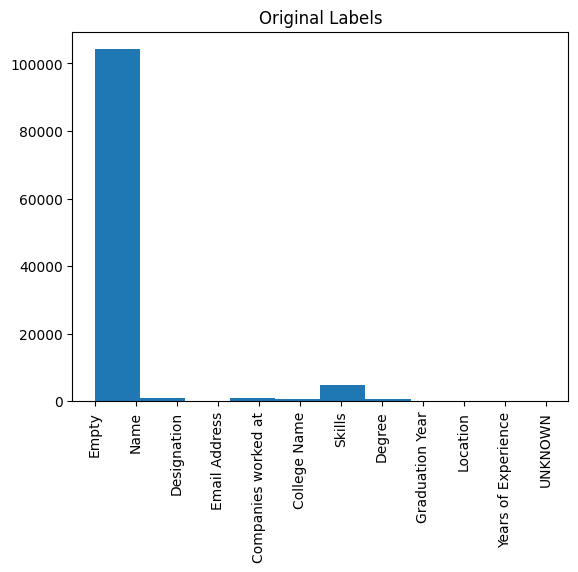

In [58]:
plot = plt.hist(np.array(true_labels).flatten())
plt.xticks(rotation='vertical')
plt.title('Original Labels')
plt.show()

In [57]:
from collections import Counter

Counter(np.array(true_labels).flatten())

Counter({'Empty': 103155,
         'Skills': 4704,
         'Designation': 1100,
         'Name': 1035,
         'Companies worked at': 908,
         'College Name': 792,
         'Degree': 598,
         'Location': 116,
         'Graduation Year': 80,
         'Email Address': 76,
         'Years of Experience': 75,
         'UNKNOWN': 1})

In [59]:
pred_labels = []

In [64]:
for i in range(len(predictions)):
    labels_for_sequence = [id2tag.get(index, "Empty") for index in predictions[i]]
    pred_labels.append(labels_for_sequence)

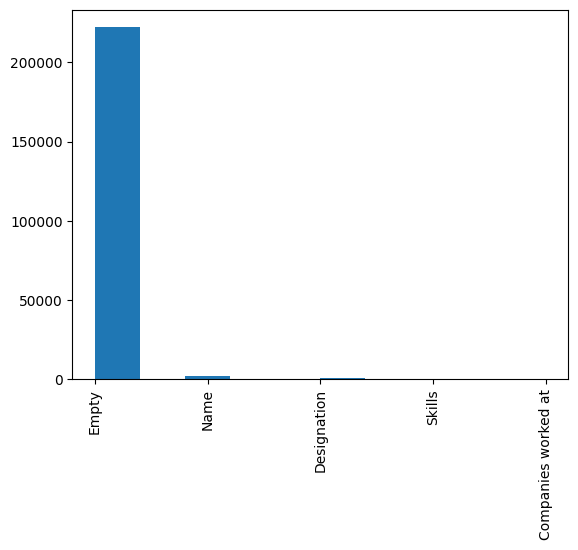

In [65]:
p = plt.hist(np.array(pred_labels).flatten())
plt.xticks(rotation='vertical')
plt.show()